In [ ]:
#https://grouplens.org/datasets/movielens/
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip  ml-latest.zip
!pip install pqdm

In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from pqdm.processes import pqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
csv_path = "ml-latest"
movies = pd.read_csv(os.path.join(csv_path, "movies.csv"))
ratings = pd.read_csv(os.path.join(csv_path, "ratings.csv"))

In [ ]:
movies.info(), ratings.info(), ratings['userId'].nunique(), ratings['movieId'].nunique()

In [ ]:
p_selection = 0.10
users = np.random.choice(ratings['userId'].unique(), size=int(ratings['userId'].nunique() * p_selection))
ratings = ratings[ratings['userId'].isin(users)]
ratings['userId'].nunique(), ratings['movieId'].nunique(), ratings.shape

In [ ]:
#Reasignar valores ID. Util para tamaño embedding
ratings['uId'] = ratings.groupby('userId').ngroup()
ratings['mId'] = ratings.groupby('movieId').ngroup()

In [ ]:
ratings = ratings.drop_duplicates(subset=['uId', 'mId'], keep='first') #Posibilidad de varias reviews
ratings.shape

## Neural Collaborative Filter

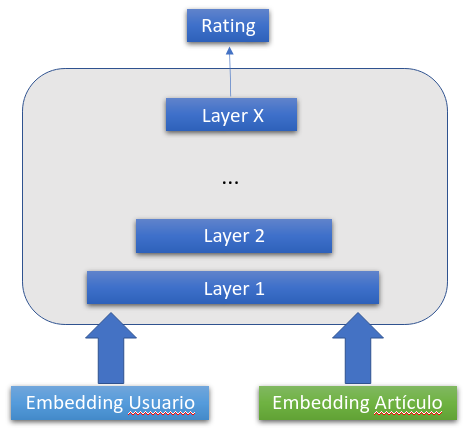

Ordenamos los valores por fecha de obtención. Por cada usuario, dejamos todos los valores para train menos el más reciente que se usará para test.

Hacemos el paso de transformar a implícito.

Para trabajar con datos implícitos tenemos que crear valores negativos. En este caso creamos 4 valores por cada 1. 4:1 rating.

In [ ]:
num_of_negatives = 3
moviesIds = ratings['mId'].unique()

def create_negatives(userId):
  user_df = train_ratings[train_ratings['uId'] == userId]
  user_movies = user_df['mId'].values
  m = moviesIds[~np.isin(moviesIds, user_movies)]
  movies = np.random.choice(m, size=num_of_negatives * user_df.shape[0])
  neg_df = pd.DataFrame({'mId': movies})
  neg_df['uId'] = userId
  neg_df['rating'] = 0
  return pd.concat([user_df, neg_df])

results =  pqdm(range(train_ratings['uId'].nunique()), create_negatives, n_jobs=2)


In [ ]:
train_ds = pd.concat(results).drop_duplicates(subset=['uId', 'mId', 'rating'], keep='first').values

In [ ]:
class TrainDataset(Dataset):

  

Creamos nuestro modelo

In [ ]:
class NCF(nn.Module):


      

In [ ]:
h_loss = []
for epoch in range(5):
  bar = tqdm(train_loader)
  bar.set_description("Loss: 0.0")
  for batch in bar:  
    user_b, movie_b, rating_b = batch.T.to(device)
    optimizer.zero_grad()
    out = model(user_b, movie_b)
    loss = lossf(out.squeeze(1), rating_b.float())
    loss.backward()
    optimizer.step()
    h_loss.append(loss.item())
    bar.set_description(f"Loss: {np.mean(h_loss[-50:]):.3f}")
  


In [ ]:
#Hit Ratio @ 10
moviesIds = set(moviesIds)
hits = []

for userId in range(test_ratings['uId'].nunique()):
  user_test_movie = test_ratings[test_ratings['uId'] == userId]['mId'].iloc[0]
  user_interacted_movies = set(ratings[ratings['uId'] == userId]['mId'])
  user_not_interacted_movies = list(moviesIds - user_interacted_movies)
  random_movies = np.random.choice(user_not_interacted_movies, size=99, replace=False)
  random_movies = np.append(random_movies,user_test_movie)
  with torch.no_grad():
    out = model(
        torch.tensor([userId] * 100).to(device),
        torch.from_numpy(random_movies).to(device)
        )
    out = torch.sigmoid(out).squeeze().cpu().numpy()
    top10 = [random_movies[i] for i in np.argsort(out)[::-1][0:10].tolist()]
    if user_test_movie in top10:
      hits.append(1)
    else:
      hits.append(0)

In [ ]:
print("The Hit Ratio @ 10 is {:.2f}".format(np.mean(hits)))